In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import pickle
import os
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms

In [15]:
# Load Dataset
def load_cifar10_batch(file_path):
    with open(file_path, 'rb') as file:
        batch = pickle.load(file, encoding='bytes')
    images = batch[b'data']  # Image data (10,000 x 3072)
    labels = batch[b'labels']  # Corresponding labels
    return images, labels

def load_cifar10_dataset(root='C:/Users/ahosain/CIFAR10/cifar-10-batches-py'):
    train_images, train_labels = [], []

    # Load all training batches (data_batch_1 to data_batch_5)
    for i in range(1, 6):
        file_path = os.path.join(root, f"data_batch_{i}")
        images, labels = load_cifar10_batch(file_path)
        train_images.append(images)
        train_labels.extend(labels)

    # Load test batch (test_batch)
    test_images, test_labels = load_cifar10_batch(os.path.join(root, "test_batch"))

    # Convert to NumPy arrays
    train_images = np.vstack(train_images).reshape(-1, 3, 32, 32).astype(np.float32)
    test_images = test_images.reshape(-1, 3, 32, 32).astype(np.float32)
    
    train_labels = np.array(train_labels, dtype=np.int64)
    test_labels = np.array(test_labels, dtype=np.int64)

    return train_images, train_labels, test_images, test_labels


In [16]:
# Load dataset
train_images, train_labels, test_images, test_labels = load_cifar10_dataset()
print(f"Train images shape: {train_images.shape}")  # Expected: (50000, 3, 32, 32)
print(f"Test images shape: {test_images.shape}")    # Expected: (10000, 3, 32, 32)

Train images shape: (50000, 3, 32, 32)
Test images shape: (10000, 3, 32, 32)


In [17]:
# Normalize images to range [-1,1]
train_images = train_images / 255.0 * 2 - 1
test_images = test_images / 255.0 * 2 - 1

In [18]:
# Convert to PyTorch tensors
train_images_tensor = torch.tensor(train_images, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)

test_images_tensor = torch.tensor(test_images, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)


In [19]:
# Create PyTorch datasets
train_dataset = TensorDataset(train_images_tensor, train_labels_tensor)
test_dataset = TensorDataset(test_images_tensor, test_labels_tensor)


In [20]:
# Create DataLoaders for batch training
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [21]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size=3072, hidden_sizes=[512, 256, 128], output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)  # Dropout to prevent overfitting
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [22]:
# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [26]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)

    val_acc = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch 1/20, Loss: 1.6375, Val Loss: 1.5277, Train Acc: 41.83%, Val Acc: 46.64%
Epoch 2/20, Loss: 1.5967, Val Loss: 1.4876, Train Acc: 43.53%, Val Acc: 48.00%
Epoch 3/20, Loss: 1.5692, Val Loss: 1.4718, Train Acc: 44.66%, Val Acc: 48.49%
Epoch 4/20, Loss: 1.5385, Val Loss: 1.4492, Train Acc: 45.60%, Val Acc: 49.38%
Epoch 5/20, Loss: 1.5156, Val Loss: 1.4451, Train Acc: 46.16%, Val Acc: 49.72%
Epoch 6/20, Loss: 1.4970, Val Loss: 1.4332, Train Acc: 47.06%, Val Acc: 49.76%
Epoch 7/20, Loss: 1.4809, Val Loss: 1.4084, Train Acc: 47.70%, Val Acc: 50.48%
Epoch 8/20, Loss: 1.4664, Val Loss: 1.4177, Train Acc: 48.27%, Val Acc: 50.04%
Epoch 9/20, Loss: 1.4488, Val Loss: 1.3865, Train Acc: 48.81%, Val Acc: 51.23%
Epoch 10/20, Loss: 1.4364, Val Loss: 1.3843, Train Acc: 49.53%, Val Acc: 51.14%
Epoch 11/20, Loss: 1.4213, Val Loss: 1.3763, Train Acc: 49.84%, Val Acc: 52.32%
Epoch 12/20, Loss: 1.4107, Val Loss: 1.3918, Train Acc: 50.26%, Val Acc: 51.15%
Epoch 13/20, Loss: 1.3985, Val Loss: 1.3767, Trai

In [27]:
# Save the trained model
torch.save(model.state_dict(), "mlp_cifar10.pth")
print("Model training complete and saved as 'mlp_cifar10.pth'.")

Model training complete and saved as 'mlp_cifar10.pth'.


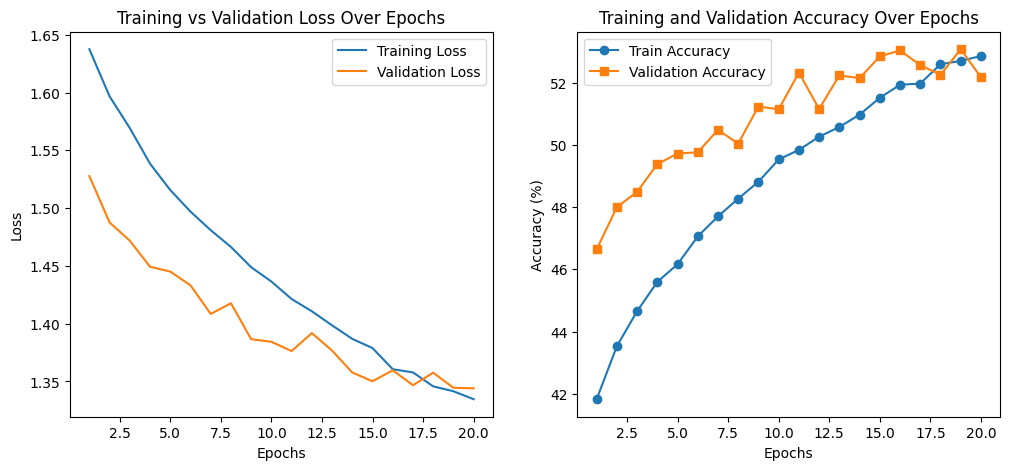

In [28]:
import matplotlib.pyplot as plt

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, marker='s', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()

In [20]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Converting lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='macro')  # Macro: Average across all classes
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.5387
Recall: 0.5323
F1 Score: 0.5289


In [21]:
class_report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)])
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.56      0.57      1000
           1       0.68      0.63      0.65      1000
           2       0.39      0.47      0.42      1000
           3       0.41      0.21      0.28      1000
           4       0.40      0.52      0.45      1000
           5       0.44      0.44      0.44      1000
           6       0.55      0.67      0.60      1000
           7       0.72      0.54      0.62      1000
           8       0.60      0.69      0.64      1000
           9       0.64      0.60      0.62      1000

    accuracy                           0.53     10000
   macro avg       0.54      0.53      0.53     10000
weighted avg       0.54      0.53      0.53     10000



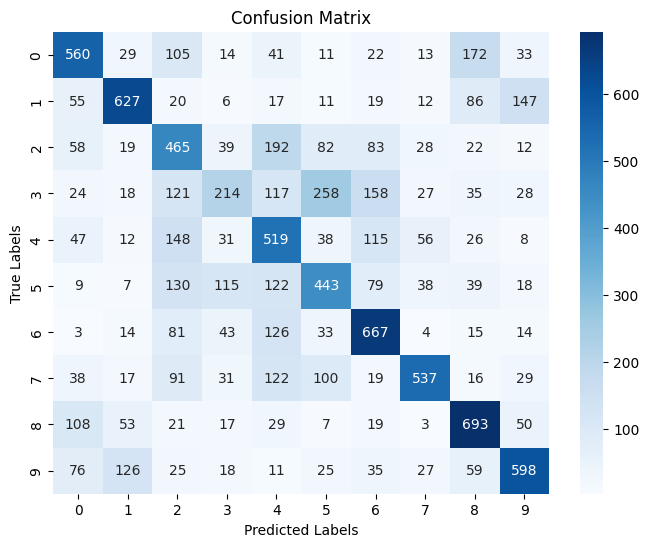

In [23]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


MLP MODEL WITH INCREASED WIDTH & DEPTH

In [29]:
# MLP Model with increased width and depth
class DeepMLP(nn.Module):
    def __init__(self, input_size=3072, hidden_sizes=[1024, 512, 256, 128, 64], output_size=10):
        super(DeepMLP, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])
        self.fc5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
        self.fc6 = nn.Linear(hidden_sizes[4], output_size)  # Output layer

        # Activation and Dropout
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    
    def forward(self, x):
        x = x.view(x.size(0), -1)  
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.relu(self.fc5(x))
        x = self.fc6(x)
        return x

In [30]:
# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DeepMLP().to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [31]:
epochs = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [39]:
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)

    val_acc = 100 * correct / total

    train_losses.append(train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "f"Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")


Epoch 1/20, Loss: 1.3257, Val Loss: 1.3296, Train Acc: 53.56%, Val Acc: 53.41%
Epoch 2/20, Loss: 1.3162, Val Loss: 1.3362, Train Acc: 53.63%, Val Acc: 53.46%
Epoch 3/20, Loss: 1.3047, Val Loss: 1.3384, Train Acc: 54.05%, Val Acc: 53.41%
Epoch 4/20, Loss: 1.3012, Val Loss: 1.3187, Train Acc: 53.97%, Val Acc: 54.01%
Epoch 5/20, Loss: 1.2872, Val Loss: 1.3273, Train Acc: 54.53%, Val Acc: 53.13%
Epoch 6/20, Loss: 1.2839, Val Loss: 1.3075, Train Acc: 54.67%, Val Acc: 54.78%
Epoch 7/20, Loss: 1.2732, Val Loss: 1.3166, Train Acc: 54.80%, Val Acc: 54.21%
Epoch 8/20, Loss: 1.2591, Val Loss: 1.3136, Train Acc: 55.59%, Val Acc: 53.98%
Epoch 9/20, Loss: 1.2604, Val Loss: 1.3250, Train Acc: 55.36%, Val Acc: 54.20%
Epoch 10/20, Loss: 1.2511, Val Loss: 1.3105, Train Acc: 55.98%, Val Acc: 54.33%
Epoch 11/20, Loss: 1.2486, Val Loss: 1.2953, Train Acc: 56.00%, Val Acc: 54.52%
Epoch 12/20, Loss: 1.2383, Val Loss: 1.3138, Train Acc: 56.33%, Val Acc: 54.05%
Epoch 13/20, Loss: 1.2339, Val Loss: 1.3092, Trai

ValueError: x and y must have same first dimension, but have shapes (20,) and (60,)

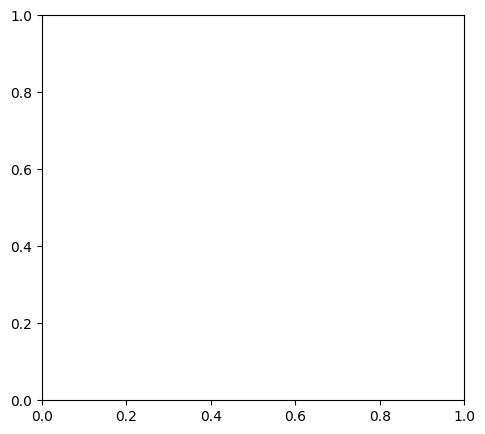

In [40]:
import matplotlib.pyplot as plt

# Plot Training Loss and Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss Over Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, epochs + 1), val_accuracies, marker='s', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training and Validation Accuracy Over Epochs")
plt.legend()

plt.show()

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_2(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Converting lists to NumPy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Precision, Recall, F1 Score
precision = precision_score(all_labels, all_preds, average='macro')  # Macro: Average across all classes
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.5390
Recall: 0.5151
F1 Score: 0.5045


In [35]:
class_report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)])
print("\nClassification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.71      0.58      1000
           1       0.69      0.64      0.67      1000
           2       0.39      0.22      0.28      1000
           3       0.29      0.56      0.38      1000
           4       0.45      0.43      0.44      1000
           5       0.54      0.14      0.22      1000
           6       0.54      0.66      0.60      1000
           7       0.69      0.56      0.62      1000
           8       0.63      0.68      0.65      1000
           9       0.67      0.55      0.60      1000

    accuracy                           0.52     10000
   macro avg       0.54      0.52      0.50     10000
weighted avg       0.54      0.52      0.50     10000



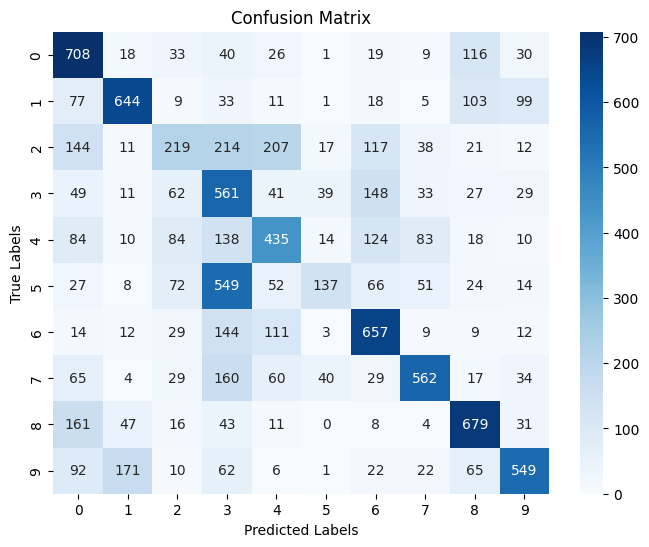

In [36]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
